# Exercises

## 1. Spam Data: 
### a. Load the spam data set.

In [57]:
import re
import unicodedata
import pandas as pd
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from bs4 import BeautifulSoup
from requests import get
import requests

#My imports
import env
import prepare as p
from importlib import reload

In [3]:
from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [5]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [6]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,n,percent
ham,4825,0.865937
spam,747,0.134063


### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

#### Breaking the data up into 3 seperate pieces:
1. The words that appear in legitimate text messages.
2. The words that appear in spam text messages.
3. All of the words.

In [9]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [18]:
spam_words

['free',
 'entry',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005',
 'text',
 'fa',
 '87121',
 'receive',
 'entry',
 'questionstd',
 'txt',
 'ratetcs',
 'apply',
 '08452810075over18s',
 'freemsg',
 'hey',
 'darling',
 '3',
 'week',
 'word',
 'back',
 'id',
 'like',
 'fun',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'send',
 'a150',
 'rcv',
 'winner',
 'valued',
 'network',
 'customer',
 'selected',
 'receivea',
 'a900',
 'prize',
 'reward',
 'claim',
 'call',
 '09061701461',
 'claim',
 'code',
 'kl341',
 'valid',
 '12',
 'hour',
 'mobile',
 '11',
 'month',
 'entitled',
 'update',
 'latest',
 'colour',
 'mobile',
 'camera',
 'free',
 'call',
 'mobile',
 'update',
 'co',
 'free',
 '08002986030',
 'six',
 'chance',
 'win',
 'cash',
 '100',
 '20000',
 'pound',
 'txt',
 'csh11',
 'send',
 '87575',
 'cost',
 '150pday',
 '6days',
 '16',
 'tsandcs',
 'apply',
 'reply',
 'hl',
 '4',
 'info',
 'urgent',
 '1',
 'week',
 'free',
 'membership',
 'a100000'

In [11]:
#Making a series from the frequency of all words, looking at spam
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [12]:
##Combining all words together in a dataframe for analysis
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [16]:
word_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8900 entries, 0 to zyada
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   all     8900 non-null   int64
 1   ham     8900 non-null   int64
 2   spam    8900 non-null   int64
dtypes: int64(3)
memory usage: 278.1+ KB


In [15]:
word_counts.sort_values(by='all', ascending=False)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
...,...,...,...
lunchtime,1,1,0
bailiff,1,0,1
lul,1,1,0
luks,1,1,0


In [17]:
spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts())
spam_bigrams

(please, call)           44
(customer, service)      27
(po, box)                24
(a1000, cash)            23
(guaranteed, call)       23
                         ..
(extreme, dirty)          1
(listen, extreme)         1
(09090900040, listen)     1
(call, 09090900040)       1
(now1, 10p)               1
Length: 6886, dtype: int64

In [20]:
#Making a word cloud, using top 20 bigrams
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                 .value_counts()
                 .head(20))

top_20_spam_bigrams

(please, call)          44
(customer, service)     27
(po, box)               24
(a1000, cash)           23
(guaranteed, call)      23
(prize, guaranteed)     22
(send, stop)            19
(selected, receive)     19
(await, collection)     19
(every, week)           19
(chance, win)           19
(urgent, mobile)        18
(land, line)            18
(valid, 12hrs)          17
(claim, call)           17
(sae, tc)               16
(account, statement)    16
(call, 08000930705)     16
(prize, claim)          16
(ur, mob)               15
dtype: int64

### Making wordcloud from spam words

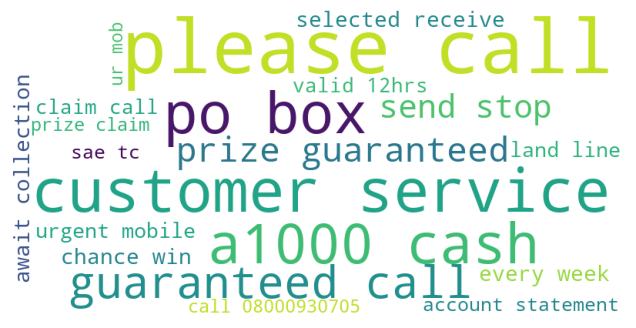

In [23]:

# Using `generate_from_frequencies` method, where  supplied values must be in the form of a dictionary,
# where the keys are the words (phrases), and the values are numbers that correspond to the sizes.
#
# Then converting series to a dictionary, and converting the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img) #use to show an image
plt.axis('off') #axes are not useful for word clouds
plt.show()


### Making word cloud for ham words for comparison

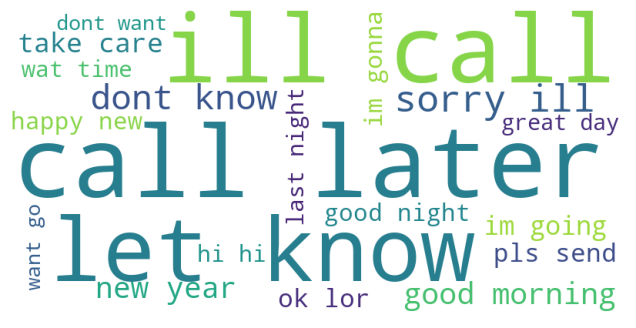

In [24]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                     .value_counts()
                     .head(20))

data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img) #use to show an image
plt.axis('off') #axes are not useful for word clouds
plt.show()

#### Some of the word cloud differences highlight more human/friendly language such as "ill call, call later", "sorry ill", "take care", while spam language is more business/money focused "please call", "send", "claim prize" etc

___

### c. Is there any overlap in the bigrams for the spam data and the ham data?

In [34]:
print(top_20_ham_bigrams.sort_values(ascending=False)), print(top_20_spam_bigrams.sort_values(ascending=False))

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
(pls, send)        22
(ok, lor)          22
(im, gonna)        20
(good, night)      19
(happy, new)       19
(wat, time)        18
(last, night)      18
(hi, hi)           18
(great, day)       17
(dont, want)       15
(want, go)         15
dtype: int64
(please, call)          44
(customer, service)     27
(po, box)               24
(a1000, cash)           23
(guaranteed, call)      23
(prize, guaranteed)     22
(await, collection)     19
(every, week)           19
(chance, win)           19
(selected, receive)     19
(send, stop)            19
(urgent, mobile)        18
(land, line)            18
(valid, 12hrs)          17
(claim, call)           17
(sae, tc)               16
(account, statement)    16
(call, 08000930705)     16
(prize, claim)          16
(ur, mob)               15
dtype: 

(None, None)

In [35]:
#Not within the first 20

### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [36]:
#Creating trigrams from spam and ham
ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts())

spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts())

ham_trigrams, spam_trigrams

((ill, call, later)      42
 (sorry, ill, call)      38
 (happy, new, year)      19
 (pls, send, message)    13
 (cant, pick, phone)     12
                         ..
 (far, knew, wasnt)       1
 (going, far, knew)       1
 (keep, going, far)       1
 (tag, keep, going)       1
 (rofl, true, name)       1
 Length: 35254, dtype: int64,
 (prize, guaranteed, call)     21
 (call, customer, service)     15
 (land, line, claim)           14
 (reply, call, 08000930705)    14
 (private, 2003, account)      13
                               ..
 (cw25wx, 150ppm, call)         1
 (326, cw25wx, 150ppm)          1
 (a5000, cash, await)           1
 (holiday, a5000, cash)         1
 (now1, 10p, per)               1
 Length: 8112, dtype: int64)

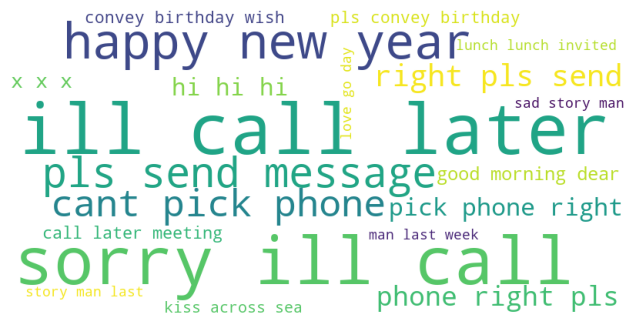

In [40]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                     .value_counts()
                     .head(20))

data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img) #use to show an image
plt.axis('off') #axes are not useful for word clouds
plt.show()

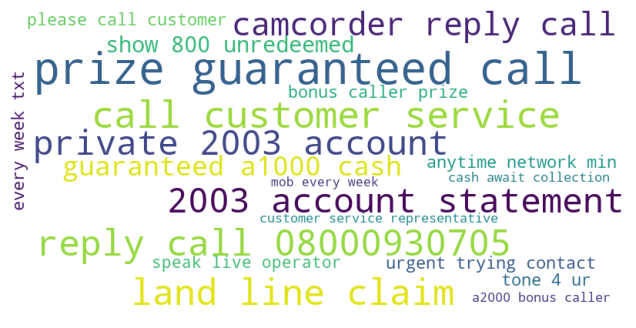

In [41]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                     .value_counts()
                     .head(20))

data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img) #use to show an image
plt.axis('off') #axes are not useful for word clouds
plt.show()

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [42]:
#codeup url
codeup_url = 'https://codeup.com/blog/'

In [51]:
def get_blog_urls(codeup_url, header = {'User-Agent': 'Codeup Data Science'}):
    soup = BeautifulSoup(requests.get(codeup_url, headers=header).content, 'html.parser')
    return [link['href'] for link in soup.select('a.more-link')]

In [52]:
get_blog_urls(codeup_url, header = {'User-Agent': 'Codeup Data Science'})

['https://codeup.com/data-science/become-a-data-scientist/',
 'https://codeup.com/employers/hiring-tech-talent/',
 'https://codeup.com/cloud-administration/cap-funding-options/',
 'https://codeup.com/dallas-info/it-professionals-dallas/',
 'https://codeup.com/codeup-news/codeup-voted-1-technical-school-in-dfw/',
 'https://codeup.com/tips-for-prospective-students/financing/codeups-scholarships/']

In [53]:
def get_blog_articles(url):
    urls = get_blog_urls(url, header = {'User-Agent': 'Codeup Data Science'})
    headers = {'User-Agent': 'Codeup Data Science'}
    output = []
    for blog in urls:
        article = BeautifulSoup(requests.get(blog, headers=headers).content)
        blog_output = {'title': article.select_one('h1.entry-title').text, 'content': article.select_one('div.entry-content').text.strip()}
        output.append(blog_output)
        
    return pd.DataFrame(output)

In [54]:
codeup_df = get_blog_articles(codeup_url)
codeup_df

,title,content
0,Become a Data Scientist in 6 Months!,Are you feeling unfulfilled in your work but w...
1,Hiring Tech Talent Around the Holidays,Are you a hiring manager having trouble fillin...
2,Cloud Administration Program New Funding Options,Finding resources to fund your educational goa...
3,Why Dallas is a Great Location for IT Professi...,"When breaking into a new career, it is importa..."
4,Codeup is ranked #1 Best in DFW 2022,We are excited to announce that Codeup ranked ...
5,Codeup’s Scholarship Offerings,In honor of November being National Scholarshi...


In [58]:
reload(p)

<module 'prepare' from '/Users/crislucin/codeup-data-science/natural-language-processing-exercises/prepare.py'>

In [59]:
codeup_df = p.organize_blog_content(codeup_df)
codeup_df

,title,original,clean,stemmed,lemmatized
0,Become a Data Scientist in 6 Months!,Are you feeling unfulfilled in your work but w...,feeling unfulfilled work want avoid returning ...,feel unfulfil work want avoid return tradit ed...,feeling unfulfilled work want avoid returning ...
1,Hiring Tech Talent Around the Holidays,Are you a hiring manager having trouble fillin...,hiring manager trouble filling position around...,hire manag troubl fill posit around holiday co...,hiring manager trouble filling position around...
2,Cloud Administration Program New Funding Options,Finding resources to fund your educational goa...,finding resources fund educational goals possi...,find resourc fund educ goal possibl largest ob...,finding resource fund educational goal possibl...
3,Why Dallas is a Great Location for IT Professi...,"When breaking into a new career, it is importa...",breaking new career important explore job oppo...,break new career import explor job opportun ex...,breaking new career important explore job oppo...
4,Codeup is ranked #1 Best in DFW 2022,We are excited to announce that Codeup ranked ...,excited announce codeup ranked 1 best tradetec...,excit announc codeup rank 1 best tradetechn sc...,excited announce codeup ranked 1 best tradetec...
5,Codeup’s Scholarship Offerings,In honor of November being National Scholarshi...,honor november national scholarship month wed ...,honor novemb nation scholarship month wed like...,honor november national scholarship month wed ...


In [62]:
#Turn all clean article content into a list
codeup_df['clean'].tolist()

['feeling unfulfilled work want avoid returning traditional educational route codeup help starting professional daunting always ideal codeup help go career bored job excites 6 months heres data science program 20week program opportunity take career new heights data science one needed jobs tech youll gather data clean explore trends apply machine learning models make predictions upon completing program know turn insights actionable recommendations youll huge asset company technical skills become data scientist projects upon projects experience belt codeup common reason individuals opt change careers fear late codeup crafted program guide career transition prove jumpstart new job age experience level decide attend codeup get support system first admissions team guide getting started well assist getting financial aid squared away program begins industry experts instructors help reach full potential complete program successfully next student experience team ready assist navigating program 

In [68]:
blog_words = codeup_df['clean'].tolist()

In [69]:
blog_words

['feeling unfulfilled work want avoid returning traditional educational route codeup help starting professional daunting always ideal codeup help go career bored job excites 6 months heres data science program 20week program opportunity take career new heights data science one needed jobs tech youll gather data clean explore trends apply machine learning models make predictions upon completing program know turn insights actionable recommendations youll huge asset company technical skills become data scientist projects upon projects experience belt codeup common reason individuals opt change careers fear late codeup crafted program guide career transition prove jumpstart new job age experience level decide attend codeup get support system first admissions team guide getting started well assist getting financial aid squared away program begins industry experts instructors help reach full potential complete program successfully next student experience team ready assist navigating program 

In [70]:
res = re.findall(r'\w+', blog_words)

TypeError: expected string or bytes-like object

In [71]:
#Make a variable for the series of clean
s = codeup_df['clean']

In [72]:
s

0    feeling unfulfilled work want avoid returning ...
1    hiring manager trouble filling position around...
2    finding resources fund educational goals possi...
3    breaking new career important explore job oppo...
4    excited announce codeup ranked 1 best tradetec...
5    honor november national scholarship month wed ...
Name: clean, dtype: object

In [73]:
#Make an empty list of words
c_blog_words = []

In [75]:
#iterating through the series
for entry in s:
    for word in entry.split(): #Splitting the sentence into words
        c_blog_words.append(word) #appending each word to the list

print(c_blog_words)

['feeling', 'unfulfilled', 'work', 'want', 'avoid', 'returning', 'traditional', 'educational', 'route', 'codeup', 'help', 'starting', 'professional', 'daunting', 'always', 'ideal', 'codeup', 'help', 'go', 'career', 'bored', 'job', 'excites', '6', 'months', 'heres', 'data', 'science', 'program', '20week', 'program', 'opportunity', 'take', 'career', 'new', 'heights', 'data', 'science', 'one', 'needed', 'jobs', 'tech', 'youll', 'gather', 'data', 'clean', 'explore', 'trends', 'apply', 'machine', 'learning', 'models', 'make', 'predictions', 'upon', 'completing', 'program', 'know', 'turn', 'insights', 'actionable', 'recommendations', 'youll', 'huge', 'asset', 'company', 'technical', 'skills', 'become', 'data', 'scientist', 'projects', 'upon', 'projects', 'experience', 'belt', 'codeup', 'common', 'reason', 'individuals', 'opt', 'change', 'careers', 'fear', 'late', 'codeup', 'crafted', 'program', 'guide', 'career', 'transition', 'prove', 'jumpstart', 'new', 'job', 'age', 'experience', 'level',